# Test `compare_venus_ctd` Module

Render figure object produced by the `nowcast.figures.publish.compare_venus_ctd` module.
Provides data for visual testing to confirm that refactoring has not adversely changed figure for web page.

Set-up and function call replicates as nearly as possible what is done in the `nowcast.workers.make_plots` worker.

Notebooks like this should be developed in a
[Nowcast Figures Development Environment](https://salishsea-nowcast.readthedocs.io/en/latest/figures/fig_dev_env.html)
so that all of the necessary dependency packages are installed.
The development has to be done on a workstation that has the Salish Sea Nowcast system `/results/` parition mounted.

In [1]:
import io
import os
from pathlib import Path

import arrow
import netCDF4 as nc
import yaml

from salishsea_tools import nc_tools

from nowcast.figures import research_VENUS
from nowcast.figures.comparison import compare_venus_ctd

In [2]:
%matplotlib inline

This figure module needs to access the ONC web services API.
Doing so requires a user token which you can generate on the Web Services API tab of your
[ONC account profile page](http://dmas.uvic.ca/Profile).
The `_prep_plot_data()` function assumes that the token will be stored in an environment variable
named `ONC_USER_TOKEN`.
You can do that using a cell like the following,
but **be careful not to commit the notebook with your token in the cell**
or you will publish it to the world in this notebook.

In [19]:
import os
os.environ['ONC_USER_TOKEN'] = 'my-token'

In [10]:
config = '''
    timezone: Canada/Pacific
    
    run_types:
        nowcast:
            config name: SalishSea
            bathymetry: /results/nowcast-sys/grid/bathymetry_201702.nc
            mesh_mask: /results/nowcast-sys/grid/mesh_mask201702.nc
        nowcast-green:
            config name: SOG
            bathymetry: /results/nowcast-sys/grid/bathymetry_201702.nc
            mesh_mask: /results/nowcast-sys/grid/mesh_mask201702.nc

    run:
        results_archive:
            nowcast: /results/SalishSea/nowcast/
            nowcast-green: /results/SalishSea/nowcast-green/
            forecast: /results/SalishSea/forecast/
'''

config = yaml.load(io.StringIO(config))

In [30]:
run_date = arrow.get('2018-10-05')
run_type = 'nowcast-green'

dmy = run_date.format('DDMMMYY').lower()
start_day = {
    'nowcast-green': run_date.format('YYYYMMDD'),
    'forecast': run_date.replace(days=+1).format('YYYYMMDD'),
}
end_day = {
    'nowcast-green': run_date.format('YYYYMMDD'),
    'forecast': run_date.replace(days=+2).format('YYYYMMDD'),
}
ymd = run_date.format('YYYYMMDD')

results_home = Path(config['run']['results_archive'][run_type])
results_dir = results_home/dmy
dev_results_home = Path(config['run']['results_archive']['nowcast-green'])
dev_results_dir = dev_results_home/dmy

In [31]:
bathy = nc.Dataset(config['run_types'][run_type]['bathymetry'])
mesh_mask = nc.Dataset(config['run_types'][run_type]['mesh_mask'])
dev_mesh_mask = nc.Dataset(config['run_types']['nowcast-green']['mesh_mask'])
grid_T_hr = nc.Dataset(
    str(results_dir/'SalishSea_1h_{0}_{1}_grid_T.nc'
        .format(start_day[run_type], end_day[run_type])))
dev_grid_T_hr = nc.Dataset(
    str(dev_results_dir/'SalishSea_1h_{0}_{1}_grid_T.nc'
        .format(start_day[run_type], end_day[run_type])))

59.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


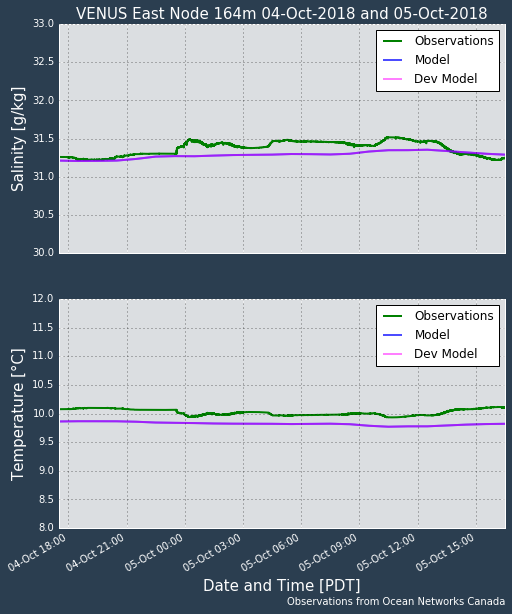

In [35]:
%%timeit -n1 -r1

# Refactored rendering of figure

from importlib import reload
from nowcast.figures import website_theme, shared
from salishsea_tools import places, data_tools
reload(compare_venus_ctd)
reload(website_theme)
reload(shared)
reload(places)
reload(data_tools)

fig = compare_venus_ctd.make_figure(
    'East node', grid_T_hr, dev_grid_T_hr, 
    config['timezone'], mesh_mask, dev_mesh_mask,
    theme=website_theme)

57.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


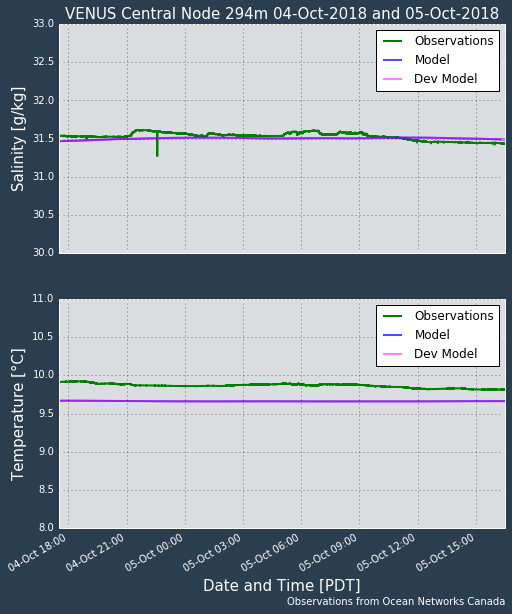

In [36]:
%%timeit -n1 -r1

# Refactored rendering of figure

from importlib import reload
from nowcast.figures import website_theme, shared
from salishsea_tools import places, data_tools
reload(compare_venus_ctd)
reload(website_theme)
reload(shared)
reload(places)
reload(data_tools)

fig = compare_venus_ctd.make_figure(
    'Central node', grid_T_hr, dev_grid_T_hr, 
    config['timezone'], mesh_mask, dev_mesh_mask,
    theme=website_theme)

1 loop, best of 1: 24.2 s per loop


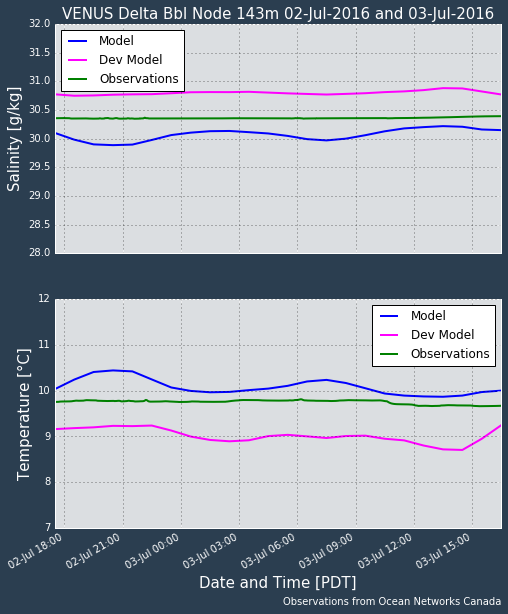

In [20]:
%%timeit -n1 -r1

# Refactored rendering of figure

from importlib import reload
from nowcast.figures import website_theme, shared
from salishsea_tools import places, data_tools
reload(compare_venus_ctd)
reload(website_theme)
reload(shared)
reload(places)
reload(data_tools)

fig = compare_venus_ctd.make_figure(
    'Delta BBL node', grid_T_hr, dev_grid_T_hr, 
    config['timezone'], mesh_mask, dev_mesh_mask,
    theme=website_theme, figsize=(8, 10))

1min 1s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


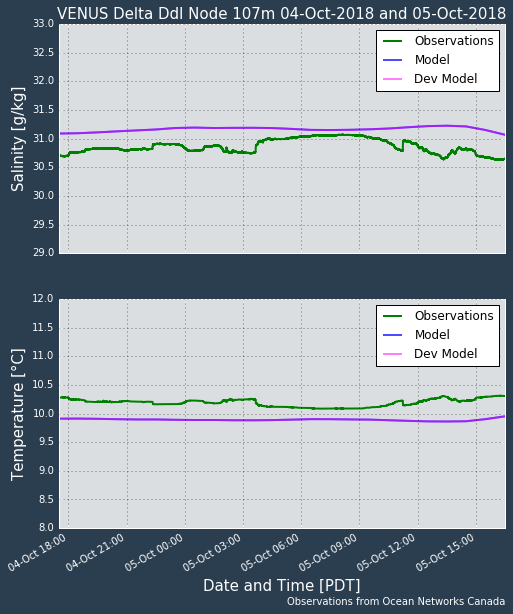

In [37]:
%%timeit -n1 -r1

# Refactored rendering of figure

from importlib import reload
from nowcast.figures import website_theme, shared
from salishsea_tools import places, data_tools
reload(compare_venus_ctd)
reload(website_theme)
reload(shared)
reload(places)
reload(data_tools)

fig = compare_venus_ctd.make_figure(
    'Delta DDL node', grid_T_hr, dev_grid_T_hr, 
    config['timezone'], mesh_mask, dev_mesh_mask,
    theme=website_theme, figsize=(8, 10))